# Project: Data Wrangling and Analysis of Twitter-based content <br> (Udacity - exclusive case study: WeRateDogs archive)

### **_by Sebastian Sbirna_**

***

## Table of Contents
- [Introduction of the topic and dataset](#intro)
- [Data Wrangling Process](#data-wrangling)
    - [Data Gathering Process](#data-gathering)
    - [Data Assessing Process](#data-assessing)
    - [Data Cleaning Process](#data-cleaning)
    - [Data Storing](#data-storing)
- [Analysis and Visualisation of Data](#data-analysis)
    - [Visualization 1](#viz-1)
    - [Visualization 2](#viz-2)
    - [Visualization 3](#viz-3)
- [Conclusion](#conclusion)

---

<a id='intro'></a>
## Introduction of the topic and dataset

Real-world data rarely comes clean. Using Python and its libraries, we gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it; a process also known as data wrangling.

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://twitter.com/dog_rates). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because ["they're good dogs Brent"](https://knowyourmeme.com/memes/theyre-good-dogs-brent). WeRateDogs has over 7.5 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive for Udacity students exclusively to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

---

<a id='data-wrangling'></a>
## Data Wrangling Process

After importing the necessary libraries, we will begin the data wrangling process, which is divided into three major steps:
- First, we will gather the necessary data from different file formats and sources, and load it into dataframes
- Secondly, we assess the data to find any inaccuracies or errors within the dataframes, both quality-related and tidiness-related
- Lastly, we perform cleaning tasks for each of the identified errors, in order to end up with a high-quality, tidy dataset

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import os
import requests as req
import json
import tweepy
import sqlalchemy

sb.set()
pd.set_option('display.max_colwidth', -1)

---
<a id='data-gathering'></a>
## 1. Data Gathering Process

Here we start our wrangling by first extracting the necessary data from its relevant sources. The first source is a file at hand containing most of the variabled related to our dataset of interest. We can import the CSV file into a pandas dataframe, like so:

In [2]:
dog_tweets_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
dog_tweets_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


The next file we will need is found at an internet location on a remote server. We can download it by establishing a connection with the server, request the file, and parse the contents of the server's response to get the needed information:

In [4]:
try:
    response = req.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
except Exception as e:
    print(e)
    
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

image_predictions_df = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
image_predictions_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


Lastly here, we will need some additional data about the tweet entries for our analysis, namely the retweet and favorite counts for each entry. Since this isn't pre-included in our CSV dataset, we have to scrape it off using the API that Twitter provides us to access content on their servers. 

_Unfortunately, at the time of writing for this project, the data able to be retrieved from the Twitter servers for the account WeRateDogs is only available beginning with entries from October 2017 onwards. Since our collection of data in the master CSV file contains entries up until 1st of August 2017, this means that we can no longer use the API to retrieve variables of interest. Fortunately, our instructor created an archive of the extended data of each tweet entry of our project, which he let us use by loading its contents from a TXT file._

_Since our `tweet-json.txt` contains a different JSON object on each separate line which must be deserialized, we need to read each JSON object one-by-one, extract the important information  to fulfill the project task, and store this data in a DataFrame._

In [6]:
tweet_json_data_df = pd.DataFrame(columns = ['tweet_id', 'nr_of_retweets', 'nr_of_favorites'])

# open the TXT file programmatically
with open('tweet-json.txt') as tweet_file:
    for line in tweet_file:
        # load its contents line by line, i.e. JSON object by JSON object
        tweet = json.loads(line)
        if ((tweet['in_reply_to_status_id'] == None) & (tweet['in_reply_to_user_id'] == None)): # if it's not a retweet or reply
            id_string = tweet['id_str']
            retweet_count = tweet['retweet_count']
            favorite_count = tweet['favorite_count']
            
            # store the additional needed information into a dataframe
            tweet_json_data_df = tweet_json_data_df.append({'tweet_id' : id_string,
                                                            'nr_of_retweets' : retweet_count,
                                                            'nr_of_favorites' : favorite_count}, 
                                                           ignore_index = True)
        else:
            continue

In [7]:
tweet_json_data_df.head(1)

,tweet_id,nr_of_retweets,nr_of_favorites
0,892420643555336193,8853,39467


Now all of the data needed has been gathered from all its necessary files, and we are ready to begin assessing it.

---
<a id='data-assessing'></a>
## 2. Data Assessing

Data assessment is needed to be thorougly performed, in order to discover any inconsistencies or imperfections in the data and correct them, before we actually being working on the analysis of the datasets. We will first assess the data visually, in order to both understand its structure and contents, and also to spot any obvious errors. Subsequently, we will continue to programmatically assess all three datasets for a deeper and more reliable investigation on the potential data quality and data tidiness errors.

### Visual Assessment

In [8]:
dog_tweets_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
809,771500966810099713,NaN,NaN,2016-09-02 00:12:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Dakota. He's just saying hi. That's all. 12/10 someone wave back https://t.co/1tWe5zZoHv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771500966810099713/photo/1,12,10,Dakota,None,None,None,None
1331,705591895322394625,NaN,NaN,2016-03-04 03:13:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Ma'am, for the last time, I'm not authorized to make that type of transaction"" 11/10 https://t.co/nPTBsdm3BF",NaN,NaN,NaN,https://twitter.com/dog_rates/status/705591895322394625/photo/1,11,10,None,None,None,None,None
2127,670319130621435904,NaN,NaN,2015-11-27 19:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670319130621435904/photo/1,11,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo
584,800141422401830912,NaN,NaN,2016-11-20 00:59:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Peaches. She's the ultimate selfie sidekick. Super sneaky tongue slip appreciated. 13/10 https://t.co/pbKOesr8Tg,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/800141422401830912/photo/1,https://twitter.com/dog_rates/status/800141422401830912/photo/1,https://twitter.com/dog_rates/status/800141422401830912/photo/1",13,10,Peaches,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60,50,a,None,None,None,None
2087,670797304698376195,NaN,NaN,2015-11-29 02:51:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Trigger. He was minding his own business on stair when he overheard someone say they don't like bacon. 11/10 https://t.co/yqohZK4CL0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670797304698376195/photo/1,11,10,Trigger,None,None,None,None
173,858471635011153920,NaN,NaN,2017-04-30 00:02:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She just arrived. Used pawority shipping. Speedy as h*ck delivery. 13/10 would carefully assemble https://t.co/8jOC4zhNxy,NaN,NaN,NaN,https://twitter.com/dog_rates/status/858471635011153920/photo/1,13,10,Sophie,None,None,None,None
1863,675372240448454658,NaN,NaN,2015-12-11 17:51:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","The tail alone is 13/10. Great dog, better owner https://t.co/IyAXinfyju",NaN,NaN,NaN,https://twitter.com/dog_rates/status/675372240448454658/photo/1,13,10,None,None,None,None,None
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Beau. He's trying to keep his daddy from packing to leave for Annual Training. 13/10 and now I'm crying https://t.co/7JeDfQvzzI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750041628174217216/photo/1,13,10,Beau,None,None,None,None


In [9]:
image_predictions_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
422,674051556661161984,https://pbs.twimg.com/media/CVq2UHwWEAAduMw.jpg,1,Shih-Tzu,0.179777,True,badger,0.160580,False,three-toed_sloth,0.132154,False
401,673689733134946305,https://pbs.twimg.com/media/CVltNgxWEAA5sCJ.jpg,1,Chesapeake_Bay_retriever,0.382220,True,American_Staffordshire_terrier,0.350140,True,seat_belt,0.098874,False
776,689661964914655233,https://pbs.twimg.com/media/CZIr5gFUsAAvnif.jpg,1,Italian_greyhound,0.322818,True,whippet,0.246966,True,Chihuahua,0.122541,True
1585,797545162159308800,https://pbs.twimg.com/media/CxFzFAAUAAA5C9z.jpg,1,Pembroke,0.954089,True,Cardigan,0.033644,True,papillon,0.009736,True
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English_setter,0.696568,True,Brittany_spaniel,0.104046,True,Ibizan_hound,0.034832,True
901,700002074055016451,https://pbs.twimg.com/media/CbboKP4WIAAw8xq.jpg,1,Chihuahua,0.369488,True,schipperke,0.243367,True,pug,0.161614,True
1515,786709082849828864,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True
59,667119796878725120,https://pbs.twimg.com/media/CUIV6F7XIAA1tAM.jpg,1,Pembroke,0.741563,True,Chihuahua,0.057866,True,toy_poodle,0.039125,True
1299,752519690950500352,https://pbs.twimg.com/media/CnF8qVDWYAAh0g1.jpg,3,swing,0.999984,False,Labrador_retriever,0.000010,True,Eskimo_dog,0.000001,True
1224,744971049620602880,https://pbs.twimg.com/media/ClarNU8VAAEDrDt.jpg,1,toy_poodle,0.497755,True,golden_retriever,0.282017,True,miniature_poodle,0.090032,True


In [10]:
tweet_json_data_df.sample(10)

,tweet_id,nr_of_retweets,nr_of_favorites
270,838561493054533637,1504,11892
1069,733828123016450049,881,3926
940,750026558547456000,888,2986
386,823322678127919110,4637,17437
1416,694352839993344000,700,2244
1740,676949632774234114,448,1413
490,810896069567610880,2090,10093
679,784517518371221505,2970,10039
918,751830394383790080,2227,6428
1604,682788441537560576,1258,2706


### Programmatic Assessment

We will make use of pandas' extensive functions to swifly determine potential problems in the data:

In [11]:
dog_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
dog_tweets_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [13]:
dog_tweets_df.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [14]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
tweet_json_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276 entries, 0 to 2275
Data columns (total 3 columns):
tweet_id           2276 non-null object
nr_of_retweets     2276 non-null object
nr_of_favorites    2276 non-null object
dtypes: object(3)
memory usage: 53.4+ KB


### Assessment errors:

From the visual and programmatic assessment done previously upon the three dataframes, we have pieced together locations of errors within the gathered data, which must first be cleaned before we can rely on this data for our analysis:

#### *__Data Quality errors:__*
- __Twitter master data - errors:__

    1. The dataset includes not only original tweets, but also re-tweets and reply tweets, which should not be present for analysis
    2. Rating numerator and denominator values are stored as `int` instead of `float` (yet there can be scores such as: 13.5)
    3. Rating numerators are not always correctly extracted (e.g. ID 883482846933004288: _numerator 5 instead of 13.5_)
    4. Rating denominators are not always correctly extracted (e.g. ID 810984652412424192: _denominator 7 instead of 10_)
    5. Some dog tweets which do not have any grading are present
    6. Tweet IDs are stored as integers, however we are not using them for any numerical calculations, so they should be strings.
    7. Timestamps are in a string, hard-to-manipulate format
    8. Some columns regarding retweeted or replied tweets should not be present in the final master dataset, since we should not have any retweets or replies in it
    9. NaN values in 'doggo', 'floofer', 'pupper' and 'puppo' are represented as 'None' strings
    10. Tweet text also contains links to the original post
    

- __Image prediction data - errors:__

    11. Predicted dog race names may small without capital letter
    12. Sometimes, spaces between predicted dog race words is represented by an underscore (_)
    13. Tweet IDs are once again stored as integers


- __Additional Twitter API data - errors:__

    Fortunately, no impactful data errors have been found in this dataset

#### *__Data Tidiness errors:__*

14. The four columns from the Twitter master dataset: 'doggo', 'floofer', 'pupper' and 'puppo', are all potential values for a common variable: dog stages. A dog may have multiple dog stages associated, case in which we will record as 'multiple'


15. The JSON-extracted dataset containing retweet counts and favorite counts for different dog IDs, as well as the image predictions for each dog tweet, are both representing variables in separate dataframes for the same observational object as the Twitter master dataset, namely the dog tweets

Since we have properly identified most of the problems related to our variables of interest, we can now begin to address the identified problems, one-by-one.

---
<a id='data-cleaning'></a>
## Data Cleaning

The last step in the data wrangling process, data cleaning will take all our previous observations related to the datasets and will perform the actual processing steps needed to achieve the most high-quality version of our data. (_This step, however, does not make our data 'better', it simply makes it as error-free as possible, so that our analyses will be the same_)

In [16]:
# Common best-practice to copy your original dataframes to avoid potential data corruption while wrangling

clean_dog_tweets = dog_tweets_df.copy()
clean_image_predictions = image_predictions_df.copy()
clean_tweet_data_json = tweet_json_data_df.copy()

### Fixing Data Quality errors:

#### a. Cleaning of *`dog_tweets_df`* dataset: 

#### 1. The dataset includes not only original tweets, but also re-tweets and reply tweets, which should not be present for analysis

__*Define solution*:__

The dataset contains the columns `in_reply_to_status_id` and `in_reply_to_user_id`, which will be populated with a Twitter ID if the entry is a reply. Similarly, `retweeted_status_id` and `retweeted_status_user_id` columns of the dataframe are populated if the entry is a retweet.

In both such situations, we can discard (_drop_) the entries, as they are irrelevant for our analysis.

__*Code for fixing*__:

In [17]:
index_for_retweets = clean_dog_tweets[clean_dog_tweets.retweeted_status_id == clean_dog_tweets.retweeted_status_id].index
index_for_replies = clean_dog_tweets[clean_dog_tweets.in_reply_to_status_id == clean_dog_tweets.in_reply_to_status_id].index

# drop entries with indexes being found to be of either retweets or replies
clean_dog_tweets.drop(index = index_for_retweets, inplace = True)
clean_dog_tweets.drop(index = index_for_replies, inplace = True)

__*Testing for results*__:

In [18]:
print('Is the dataset clean of replies?')
print(clean_dog_tweets[clean_dog_tweets.in_reply_to_user_id == clean_dog_tweets.in_reply_to_user_id].empty)

print()

print('Is the dataset clean of retweets?')
print(clean_dog_tweets[clean_dog_tweets.retweeted_status_user_id == clean_dog_tweets.retweeted_status_user_id].empty)

Is the dataset clean of replies?
True

Is the dataset clean of retweets?
True


#### 2. Rating numerator and denominator values are stored as int instead of float (yet there can be scores such as: 13.5)

__*Define solution*:__

For accurate storage of information, we should change the datatype of both numerator and denominator to `float`.

__*Code for fixing*__:

In [19]:
# converting column variable type to float type
clean_dog_tweets.rating_numerator = clean_dog_tweets.rating_numerator.astype(float)
clean_dog_tweets.rating_denominator = clean_dog_tweets.rating_denominator.astype(float)

__*Testing for results*__:

In [20]:
print(clean_dog_tweets.rating_numerator.dtype)
print(clean_dog_tweets.rating_denominator.dtype)

float64
float64


#### 3. Rating numerators are not always correctly extracted (e.g. ID 883482846933004288: numerator 5 instead of 13.5)

__*Define solution*:__

For each tweet, we have its original text, which contains the ratings in the form: `numerator/denominator`. We will redo the operation of extraction of the numerator from the text, using the `split` and `find` methods of strings to our advantage.

__*Code for fixing*__:

In [21]:
def extract_numerator(row):
    numerator_text = row.text.split('/', maxsplit = 1)[0] # this is all the text to the left of the backslash between numerator and denominator

    try:
        # we are trying to use regex to find the numerator digits within the tweet text
        numerator_index = re.search(r'(\d{1,5}\.?\d*)/', row.text).start(0) # index of first digit of the numerator
        
        # we select all characters from the first numerator digit to the split character ('/') (however this string ends at the split character)
        numerator = float(numerator_text[numerator_index:])
        row.rating_numerator = numerator
    except:
        row.rating_numerator = None
    
    return row

clean_dog_tweets = clean_dog_tweets.apply(lambda row: extract_numerator(row), axis = 1)

__*Testing for results*__:

In [22]:
clean_dog_tweets.rating_numerator.value_counts()

12.00      485
10.00      436
11.00      413
13.00      287
9.00       153
8.00       98 
7.00       52 
14.00      38 
5.00       33 
6.00       32 
3.00       18 
4.00       16 
2.00       9  
1.00       5  
13.50      1  
0.00       1  
24.00      1  
84.00      1  
420.00     1  
1776.00    1  
80.00      1  
60.00      1  
44.00      1  
144.00     1  
88.00      1  
11.26      1  
11.27      1  
121.00     1  
9.75       1  
99.00      1  
204.00     1  
45.00      1  
165.00     1  
50.00      1  
Name: rating_numerator, dtype: int64

In [23]:
clean_dog_tweets[clean_dog_tweets.tweet_id == 883482846933004288].rating_numerator

45    13.5
Name: rating_numerator, dtype: float64

#### 4. Rating denominators are not always correctly extracted (e.g. ID 810984652412424192: denominator 7 instead of 10)

__*Define solution*:__

For each tweet, we have its original text, which contains the ratings in the form: `numerator/denominator`. We will redo the operation of extraction of the denominator from the text, using the `split` and `find` methods of strings to our advantage.

__*Code for fixing*__:

In [24]:
def extract_denominator(row):
    denominator_text = row.text.split('/', maxsplit = 1)[1] # this is all the text to the right of the backslash between numerator and denominator
    
    try:
        first_whitespace_index = re.search(r'[^0-9\.]', denominator_text).start(0) # whitespace delimiting denominator and other next parts of sliced string
        
        # we select all characters from the start of the split string up to the first whitespace character
        denominator = float(denominator_text[: first_whitespace_index])
        row.rating_denominator = denominator
    except:
        row.rating_denominator = None
    
    return row

clean_dog_tweets = clean_dog_tweets.apply(lambda row: extract_denominator(row), axis = 1)

__*Testing for results*__:

In [25]:
clean_dog_tweets.rating_denominator.value_counts()

10.0     2078
50.0     3   
80.0     2   
11.0     2   
150.0    1   
110.0    1   
90.0     1   
70.0     1   
170.0    1   
2.0      1   
120.0    1   
40.0     1   
20.0     1   
7.0      1   
Name: rating_denominator, dtype: int64

In [26]:
print('Are there any tweet entries without numerator, yet with denominator?')
print(not clean_dog_tweets[
    (clean_dog_tweets.rating_numerator != clean_dog_tweets.rating_numerator) & 
    (clean_dog_tweets.rating_denominator == clean_dog_tweets.rating_denominator)].empty)

print()

print('Are there any tweet entries with numerator, yet without denominator?')
print(not clean_dog_tweets[
    (clean_dog_tweets.rating_numerator == clean_dog_tweets.rating_numerator) & 
    (clean_dog_tweets.rating_denominator != clean_dog_tweets.rating_denominator)].empty)

Are there any tweet entries without numerator, yet with denominator?
False

Are there any tweet entries with numerator, yet without denominator?
False


#### 5. Some dog tweets which do not have any grading are present

__*Define solution*:__

After more visual assessment was done, it was found that only tweet ID 810984652412424192 has this property. 
Therefore, to fix this problem, it is best to drop the entry with ID 810984652412424192.

__*Code for fixing*__:

In [27]:
clean_dog_tweets.drop(index = clean_dog_tweets[clean_dog_tweets.tweet_id == 810984652412424192].index, inplace = True)

__*Testing for results*__:

In [28]:
clean_dog_tweets[clean_dog_tweets.text.str.find('/10') == -1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84.0,70.0,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150.0,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170.0,this,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,90.0,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,50.0,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,50.0,a,None,None,None,None
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40.0,None,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868335505415/photo/1,121.0,110.0,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515794329600/photo/1,144.0,120.0,None,None,None,None,None


#### 6. Tweet IDs are stored as integers, however we are not using them for any numerical calculations, so they should be strings.

__*Define solution*:__

We should update the dataframe type of Tweet IDs to reflect strings.

__*Code for fixing*__:

In [29]:
# converting IDs type to strings
clean_dog_tweets.tweet_id = clean_dog_tweets.tweet_id.astype(str)

__*Testing for results*__:

In [30]:
print(clean_dog_tweets.tweet_id.dtype)

object


#### 7. Timestamps are in a string, hard-to-manipulate format

__*Define solution*:__

The Pandas function `to_datetime()` can be used to properly store dates to `datetime64` objects, for easy manipulation.

__*Code for fixing*__:

In [31]:
clean_dog_tweets.timestamp = pd.to_datetime(clean_dog_tweets.timestamp)

__*Testing for results*__:

In [32]:
print(clean_dog_tweets.timestamp.dtype)

datetime64[ns]


#### 8. Some columns regarding retweeted or replied tweets should not be present in the final master dataset, since we should not have any retweets or replies in it

__*Define solution*:__

Since we have tested that our dataset does not contain any more retweets or reply entries, it is efficient to drop the columns that previously helped us in finding such entries.

__*Code for fixing*__:

In [33]:
# drop unnecessary
clean_dog_tweets.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'in_reply_to_status_id', 
                                 'in_reply_to_user_id', 'retweeted_status_timestamp'], inplace = True)

__*Testing for results*__:

In [34]:
print(list(clean_dog_tweets.columns))

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


#### 9. NaN values in 'doggo', 'floofer', 'pupper' and 'puppo' are represented as 'None' strings

__*Define solution*:__

We can replace 'None' string values in any of these four columns with NaN.

__*Code for fixing*__:

In [35]:
clean_dog_tweets.doggo = clean_dog_tweets.doggo.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
clean_dog_tweets.floofer = clean_dog_tweets.floofer.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
clean_dog_tweets.pupper = clean_dog_tweets.pupper.apply(lambda entry: pd.np.nan if entry == 'None' else entry)
clean_dog_tweets.puppo = clean_dog_tweets.puppo.apply(lambda entry: pd.np.nan if entry == 'None' else entry)

__*Testing for results*__:

In [36]:
clean_dog_tweets[['doggo', 'floofer', 'pupper', 'puppo']].head(15)

,doggo,floofer,pupper,puppo
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,doggo,NaN,NaN,NaN


#### 10. Tweet text also contains links to the original post

__*Define solution*:__

We can remove the links in the string by splitting the string into _text part_ and _link part_, and only saving the first part.

__*Code for fixing*__:

In [37]:
clean_dog_tweets.text = clean_dog_tweets.text.apply(lambda text: text.split('http')[0])

__*Testing for results*__:

In [38]:
# generate 5 random examples of text, in order to check whether the links are indeed removed from the main text
for i in np.arange(0, 5):
    rand_nr = np.random.randint(0, 100 + 1)
    
    # we need to specify a try-except block here, since if our random number happens to be an index of a previously-removed 
    # retweet or reply, it will return an error
    try:
        print(clean_dog_tweets.text[rand_nr])
        print()
    except:
        continue

This is Lola. It's her first time outside. Must test the earth and taste the atmosphere. 13/10 you're doing great Lola 

Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af 
(IG: puffie_the_chow) 

Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek 

Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af 
(IG: puffie_the_chow) 

This is Oliver. You're witnessing one of his many brutal attacks. Seems to be playing with his victim. 13/10 fr*ckin frightening #BarkWeek 



#### b. Cleaning of *`image_predictions_df`* dataset: 

#### 11. Predicted dog race names may small without capital letter

__*Define solution*:__

We need to capitalize the first letter of each dog race string.

__*Code for fixing*__:

In [39]:
# Capitalize the first letter of each dog race field
clean_image_predictions.p1 = clean_image_predictions.p1.str.title()
clean_image_predictions.p2 = clean_image_predictions.p2.str.title()
clean_image_predictions.p3 = clean_image_predictions.p3.str.title()

__*Testing for results*__:

In [40]:
print(clean_image_predictions.p1.head(2))
print()
print(clean_image_predictions.p2.head(2))
print()
print(clean_image_predictions.p3.head(2))

0    Welsh_Springer_Spaniel
1    Redbone               
Name: p1, dtype: object

0    Collie            
1    Miniature_Pinscher
Name: p2, dtype: object

0    Shetland_Sheepdog  
1    Rhodesian_Ridgeback
Name: p3, dtype: object


#### 12. Sometimes, spaces between predicted dog race words is represented by an underscore (_)

__*Define solution*:__

We can replace the underscore character (_) with a whitespace, since we know there should never be an underscore in that field.

__*Code for fixing*__:

In [41]:
# Replace underscores in string with whitespace characters
clean_image_predictions.p1 = clean_image_predictions.p1.str.replace('_', ' ')
clean_image_predictions.p2 = clean_image_predictions.p2.str.replace('_', ' ')
clean_image_predictions.p3 = clean_image_predictions.p3.str.replace('_', ' ')

__*Testing for results*__:

In [42]:
print(clean_image_predictions.p1.head(2))
print()
print(clean_image_predictions.p2.head(2))
print()
print(clean_image_predictions.p3.head(2))

0    Welsh Springer Spaniel
1    Redbone               
Name: p1, dtype: object

0    Collie            
1    Miniature Pinscher
Name: p2, dtype: object

0    Shetland Sheepdog  
1    Rhodesian Ridgeback
Name: p3, dtype: object


#### 13. Tweet IDs are once again stored as integers

__*Define solution*:__

We should update the dataframe type of Tweet IDs to reflect strings.

__*Code for fixing*__:

In [43]:
# converting IDs type to strings
clean_image_predictions.tweet_id = clean_image_predictions.tweet_id.astype(str)

__*Testing for results*__:

In [44]:
print(clean_image_predictions.tweet_id.dtype)

object


### Fixing Data Tidiness errors:

#### 14. The four columns from the Twitter master dataset: 'doggo', 'floofer', 'pupper' and 'puppo', are all potential values for a common variable: dog stages. A dog may have multiple dog stages associated, case in which we will record as 'multiple'

__*Define solution*:__

We need to appropriately __*melt*__ the four columns for dog stages into one, resulting in each Twitter dog entry having either 'multiple' dog stages, or one of the possible 4 dog stage values, or None if the dog entry does not have any stage.

__*Code for fixing*__:

In [45]:
def write_dog_stage(entry):
    total_nr_of_stages = entry[['doggo', 'floofer', 'pupper', 'puppo']].count().sum()
    
    if (total_nr_of_stages > 1):
        return 'Multiple'
    else:
        if (entry.doggo == entry.doggo):
            return 'Doggo'
        elif (entry.floofer == entry.floofer):
            return 'Floofer'
        elif (entry.pupper == entry.pupper):
            return 'Pupper'
        elif (entry.puppo == entry.puppo):
            return 'Puppo'
    return pd.np.nan

clean_dog_tweets['dog_stage'] = clean_dog_tweets.apply(lambda row: write_dog_stage(row), axis = 1)

In [46]:
clean_dog_tweets = clean_dog_tweets.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

__*Testing for results*__:

In [47]:
clean_dog_tweets.dog_stage.value_counts()

Pupper      221
Doggo       72 
Puppo       23 
Multiple    11 
Floofer     9  
Name: dog_stage, dtype: int64

#### 15. The JSON-extracted dataset containing retweet counts and favorite counts for different dog IDs, as well as the image predictions for each dog tweet, are both representing variables in separate dataframes for the same observational object as the Twitter master dataset, namely the dog tweets

__*Define solution*:__

In order to have all the representational data about the dog tweet entries in one place, we will join together the `clean_dog_tweets` with the `image_predictions` and the `clean_tweet_data_json` datasets.

__*Code for fixing*__:

In [48]:
# Merge dog_tweets and image_predictions on tweet ID
clean_dog_tweets = pd.merge(clean_dog_tweets, clean_image_predictions, how = 'inner', on = 'tweet_id')
# Merge the newly-updated dog_tweets and tweet_data_json on tweet ID
clean_dog_tweets = pd.merge(clean_dog_tweets, clean_tweet_data_json, how = 'inner', on = 'tweet_id')

__*Testing for results*__:

In [49]:
clean_dog_tweets.head().iloc[0]

tweet_id              892420643555336193                                                                    
timestamp             2017-08-01 16:23:56                                                                   
source                <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>    
text                  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 
expanded_urls         https://twitter.com/dog_rates/status/892420643555336193/photo/1                       
rating_numerator      13                                                                                    
rating_denominator    10                                                                                    
name                  Phineas                                                                               
dog_stage             NaN                                                                                   
jpg_url            

#### Final step:

Since our Twitter master dataset variables needed for our analysis are now cleaned, the last steps in the data wrangling process would be to remove the unnecessary columns, which have also been left unwrangled, and save our dataset to local storage for further processing and archiving.

In [50]:
clean_dog_tweets.drop(columns = ['source', 'expanded_urls'], inplace = True)

<a id='data-storing'></a>
### Data Storing

Now that we have computed all the modification steps upon our datasets, it is good practice to save our results for further easier reloading and processing of its contents. It helps machines performing the analysis in avoiding to redo the entire computational process to clean the data (in some cases), and it certainly helps in sharing and distribution of data across teams and groups.

In [51]:
clean_dog_tweets.to_csv('twitter_archive_master.csv', index = False) # Storing the master dataset to CSV

if (os.path.exists('udacity_data_wrangling.db') == False): # For additional storage, we will save the dataframes as tables in a SQL database
    sql_engine = sqlalchemy.create_engine('sqlite:///udacity_data_wrangling.db')
    clean_dog_tweets.to_sql('twitter_archive_master_table', sql_engine, index = False)

---
<a id='data-analysis'></a>
## Analysis and Visualisation of Data

Now that our data has been gathered from the right sources, assessed, and cleaned for all variables of interest, it is possible to make reliable analysis insights, based on three different questions/leads, as we present below. 

<a id='viz-1'></a>
### Visualisation 1

First, since WeRateDogs is known for its unique dog ratings which often surpass the default scoring scale, we are interested in seeing which ratings (numerators) have been most popular across the entire set of tweets:

In [52]:
ratings = clean_dog_tweets.rating_numerator.value_counts().index[0:5]
rating_counts = clean_dog_tweets.rating_numerator.value_counts().values[0:5]

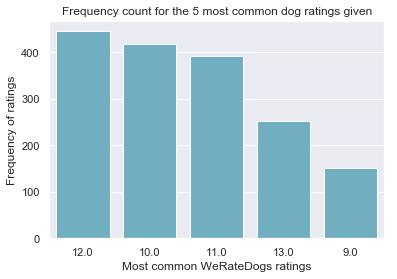

In [53]:
sb.barplot(x = ratings, y = rating_counts, order = ratings, color = sb.color_palette()[9]);

plt.xlabel('Most common WeRateDogs ratings');
plt.ylabel('Frequency of ratings');
plt.title('Frequency count for the 5 most common dog ratings given');

### Data Insight 1:

The most common ratings given by WeRateDogs are **_12/10_** and **_10/10_**, followed by **_11/10_**, **_13/10_** and **_9/10_**. Their recorded number of apparitions in the dataset can be seen from the graph above.

---
<a id='viz-2'></a>
### Visualisation 2

Next, since we know that not all rates dogs have been attributed a dog stage, we would like to find out the distribution of dog stages across our master dataset.

In [54]:
# extraction of dog stage names
stages = clean_dog_tweets.dog_stage.value_counts().index
# extraction of dog stage counts
stage_counts = clean_dog_tweets.dog_stage.value_counts().values

stage_count_total = clean_dog_tweets.dog_stage.value_counts().values.sum()

In [55]:
clean_dog_tweets.dog_stage.value_counts(1)

Pupper      0.663366
Doggo       0.207921
Puppo       0.072607
Multiple    0.033003
Floofer     0.023102
Name: dog_stage, dtype: float64

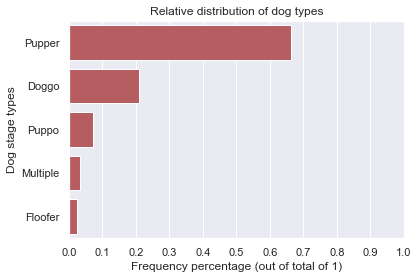

In [56]:
sb.barplot(x = (stage_counts / stage_count_total), y = stages, order = stages, color = sb.color_palette()[3]);

plt.title('Relative distribution of dog types');
plt.xlabel('Frequency percentage (out of total of 1)');
plt.ylabel('Dog stage types');

# set the x-label ticks correspondingly, to show 10% units increase every time, until 100%
plt.xticks(np.arange(0, 1 + 0.1, 0.1));

### Data Insight 2:

It can be seen from the graph above that most dogs in our dataset, for which a dog type has been recorded, are of type **_pupper_**, which account for 66.3% of the total distribution. **_Doggo_** is next in line, accounting for 20.8% of the total distribution, while **_puppo_** and **_floofer_** follow afterwards, with lower percentages. 3.3% of the dogs with some recorded dog type are actually registered with **_multiple_** dog types.

---
<a id='viz-3'></a>
### Visualisation 3

For our final insight, we are interested in investigating which _three_ **named** dogs have received most retweets and, separately, which _three_ **named** dogs received most favorites. Afterwards, we will extract the actual posted picture of the winner for each category using the image URL found in the `dog_tweets` dataset. (_Notice that dogs with higher retweet or favorite count, but for which we don't know their names will not be considered_)

In [57]:
# construct new temporary dataframe, sorted after retweet count
retweet_highest_df = clean_dog_tweets[['tweet_id', 'name', 'nr_of_retweets']].sort_values(by = 'nr_of_retweets', ascending = False)
# drop all dog entries without any known name
retweet_highest_df.drop(index = retweet_highest_df[retweet_highest_df.name == 'None'].index, inplace = True)

# perform analysis on the top 3 most popular entries
retweet_highest_count = retweet_highest_df.nr_of_retweets[:3].values
retweet_highest_names = retweet_highest_df.name[:3].values

# the mean value is needed for horizontal line of reference
retweet_mean = clean_dog_tweets.nr_of_retweets.mean()

In [58]:
# construct new temporary dataframe, sorted after favorite count
favorite_highest_df = clean_dog_tweets[['tweet_id', 'name', 'nr_of_favorites']].sort_values(by = 'nr_of_favorites', ascending = False)
# drop all dog entries without any known name
favorite_highest_df.drop(index = favorite_highest_df[favorite_highest_df.name == 'None'].index, inplace = True)

# perform analysis on the top 3 most popular entries
favorite_highest_count = favorite_highest_df.nr_of_favorites[:3].values
favorite_highest_names = favorite_highest_df.name[:3].values

# the mean value is needed for horizontal line of reference
favorite_mean = clean_dog_tweets.nr_of_favorites.mean()

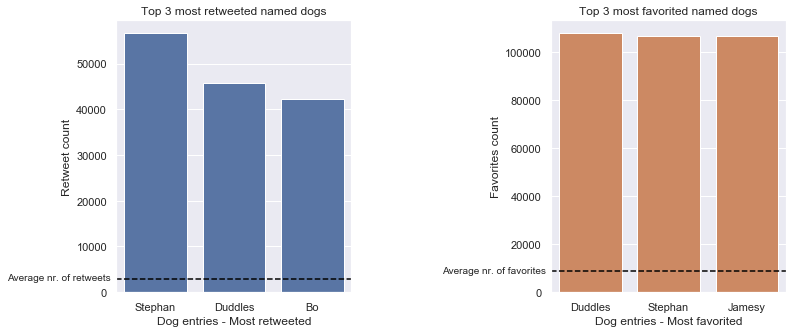

In [59]:
plt.figure(figsize = [12, 5])
plt.subplots_adjust(wspace = 0.85) # adjust spacing between subplots

plt.subplot(1, 2, 1);
ax = sb.barplot(x = retweet_highest_names, y = retweet_highest_count, color = sb.color_palette()[0]);

plt.xlabel('Dog entries - Most retweeted');
plt.ylabel('Retweet count');
plt.title('Top 3 most retweeted named dogs');

plt.axhline(retweet_mean, linestyle = '--', color = 'black'); # plot a line of reference to what would be average amount of retweets
ax.text(0, 0.0425, 'Average nr. of retweets  ', horizontalalignment='right', transform = ax.transAxes);

plt.subplot(1, 2, 2);
ax = sb.barplot(x = favorite_highest_names, y = favorite_highest_count, color = sb.color_palette()[1]);

plt.xlabel('Dog entries - Most favorited');
plt.ylabel('Favorites count');
plt.title('Top 3 most favorited named dogs');

plt.axhline(favorite_mean, linestyle = '--', color = 'black'); # plot a line of reference to what would be average amount of favorites
ax.text(0, 0.07, 'Average nr. of favorites  ', horizontalalignment='right', transform = ax.transAxes);

From here, we will discover the JPG URLs of each of the winners and embed them into `img src` HTML tags within the Jupyter Notebook, for presentation purposes. 

The following snippet of code prints the JPG URL needed for copying into the notebook:

In [60]:
# Snippet needed for printing out and embedding the direct URL of the entry winners' images

print(clean_dog_tweets[clean_dog_tweets.tweet_id == '807106840509214720'].jpg_url)
print(clean_dog_tweets[clean_dog_tweets.tweet_id == '879415818425184262'].jpg_url)
print(clean_dog_tweets[clean_dog_tweets.tweet_id == '819004803107983360'].jpg_url)

print()

print(clean_dog_tweets[clean_dog_tweets.tweet_id == '879415818425184262'].jpg_url)
print(clean_dog_tweets[clean_dog_tweets.tweet_id == '807106840509214720'].jpg_url)
print(clean_dog_tweets[clean_dog_tweets.tweet_id == '866450705531457537'].jpg_url)

396    https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg
Name: jpg_url, dtype: object
58    https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg
Name: jpg_url, dtype: object
330    https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg
Name: jpg_url, dtype: object

58    https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg
Name: jpg_url, dtype: object
396    https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg
Name: jpg_url, dtype: object
108    https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg
Name: jpg_url, dtype: object


### Data Insight 3: 
_Here we have the popularity champions from this dataset:_

- _For the 'retweet' rankings, we have:_
    - #### _1st place, Stephan, with 56625 retweets:_
<br>
<img src="https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg" style="width:35%">
<br>
    - #### _2nd place, Duddles, with 45849 retweets:_
<br>
<img src="https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg" style="width:50%">
<br>
    - #### _3rd place, Bo, with 42228 retweets:_
<br>
<img src="https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg" style="width:35%">
<br>

- _For the 'favorites' rankings, we have:_
    - #### _1st place, Duddles, with 107956 favorites:_
<br>
<img src="https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg" style="width:50%">
<br>
    - #### _2nd place, Stephan, with 107015 favorites:_
<br>
<img src="https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg" style="width:35%">
<br>
    - #### _3rd place, Jamesy, with 106827 favorites:_
<br>
<img src="https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg" style="width:50%">

---
<a id='conclusion'></a>
## Conclusion:

_We have analysed a dataset recollecting dog ratings from the famous Twitter reviewer WeRateDogs. Before analysis was possible, the data needed for insight finding was unclean and scattered throughout multiple sources. Therefore, the basis of this project has been the completion of a thorough Data Wrangling process, going through all the needed steps of data gathering, assessment and cleaning._

- _First, we have extracted the necessary data from multiple file formats, stored both locally and online. Some variables however, such as retweet and favorite count, could not be found in the files at hand, so they needed to be scraped directly from the Twitter web servers using their provided APIs. Unfortunately, the Tweeter database is constantly adding and deleting new information, and in the case of WeRateDogs, any posting after October 2017 is no longer available for scraping. Since our data contains all tweets up until August 2017, we had to rely on loading the necessary data from a file archive provided by the course instructor._


- _After the gathering process was completed, we had to assess our data, visually and programmatically, in order to understand its representation in our dataframes, and identify any data quality or tidiness errors which can affect our analysis. The datasets have been analysed, one-by-one, using functions from the Pandas library, and 15 issues were documented throughout the process. It should be mentioned that this list of issues is not exhaustive, but it consists of the necessary issues related to our variables of interest._


- _The data cleaning process itself was always divided into three steps, for each of the issues involved: first, a solution to the error was described, after which the necessary coding was written, and lastly, we would create appropriate tests to verify whether the error is no longer present._


- _At the end of data cleaning, the result was more easily-processable and error-free datasets. Considering this, it is helpful to store these modified datasets locally, so that their processing does not need to be reiterated. The datasets were stored both in CSV formats and in a SQL database as tables._

_Lastly, analysis has been performed upon the cleaned datasets, and we were able to discover which ratings were most frequently given to the dogs in our dataset, what the distribution of dog types was over our dataset, and figure out the winners of popularity in terms of retweet counts and favorite counts._